In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In this notebook, we utilize transformer structure to create a Image Captioning model with Pretrained Vit and transformer decoder.

## Image Captioning Model with Pretrained ViT + Transformer Decoder

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import collections
import re
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Data Load and Transform

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print('total number of unique image: ', len(df['image'].unique()))
print('total number of df: ', len(df))

## plan to use 6091 for training, 1000 for val and 1000 for test

## [0:6091*5 = 30455 ] traing
## [30455:35455,:] val
## [35355: , :] test

total number of unique image:  8091
total number of df:  40455


In [ ]:
df_train = df.iloc[:30455, :].reset_index()
df_val = df.iloc[30455:35455,:].reset_index()
df_test= df.iloc[35455:,:].reset_index()

print(len(df_train))
print(len(df_val))
print(len(df_test))

30455
5000
5000


In [ ]:
class Vocab:
    def __init__(self, tokens = None, minimum_frequency = 0 , reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        if len(tokens) == 0 or isinstance(tokens, list):
            tokens = [token for line in tokens for token in line]
            counter = collections.Counter(tokens)
        else:
            raise Exception('tokens should be a list of list')

        self._token_frequence = sorted(counter.items(), key = lambda x: x[1], reverse = True)

        self.index_to_token = ['<UNK>'] + reserved_tokens 
        self.token_to_index = {token: index for index , token in enumerate(self.index_to_token)}

        for token , frequency in self._token_frequence: 
            if frequency < minimum_frequency:
                # because we have already sorted the dictionary in decreasing order
                break

            if token not in self.token_to_index:
                self.index_to_token.append(token)
                self.token_to_index[token] = len(self.index_to_token) - 1

    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index.get(tokens, 0) # 0 is the index for <UNK>
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.index_to_token[indices]

        return [self.index_to_token[index] for index in indices]


## Create vocabulary here

In [ ]:
tokens = [line.lower().split() for line in df.caption.tolist()]
reserved_tokens = ['<BOS>','<EOS>','<PAD>']
minimum_frequency = 1
vocab = Vocab(tokens,minimum_frequency,reserved_tokens)

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_path, transform = None, df = None, vocab = None):
        self.image_path = image_path
        self.transform = transform

        self.df = df

        self.img = self.df['image']
        self.caption = self.df['caption']
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.img[index]
        caption = self.caption[index]

        image = Image.open(os.path.join(self.image_path, image)).convert('RGB')

        if self.transform != None:
            image = self.transform(image)

        token = caption.lower().split()

        #return image, torch.tensor([self.vocab['<BOS>']] + self.vocab[token] + [self.vocab['<EOS>']])
        return image, torch.tensor( self.vocab[token] + [self.vocab['<EOS>']])

## Create traindata set, validation dataest and test dataset

In [ ]:
class Mycollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self,batch):
        images = [i[0].unsqueeze(0) for i in batch] #batch is image and caption -> image = batch[0], caption = batch[1]
        images = torch.cat(images, dim = 0)

        targets = [i[1] for i in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)

        return images, targets

In [ ]:
image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'
caption_path = "/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt"

class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean


transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #AddGaussianNoise(0,1)
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_path, transform = transform, df = df_train, vocab = vocab)
val_dataset = Flickr8kDataset(image_path, transform = transform,  df = df_val, vocab = vocab )

print(len(train_dataset), len(val_dataset))

pad_idx = vocab['<PAD>']

train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = 64,
      num_workers = 4,
      shuffle = True,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

val_dataloader = DataLoader(
      dataset = val_dataset,
      batch_size = 32,
      num_workers = 2,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )


30455 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Create CNN and RNN

In [ ]:
!pip install -q torchinfo

from torchinfo import summary

from torchvision.models import vit_b_32
ViT = vit_b_32(weights = 'IMAGENET1K_V1')

for param in ViT.parameters():
    param.requires_grad = False

In [ ]:
class encoderCNN(nn.Module):
    ## since we are using the pretrained resnet image input (batch_size, 3, 224, 224)
    ## output size: (hidden_layer = 1, batch_size, hidden_size)
    def __init__(self, hidden_size, num_channels = 3, patch_size = 16, embedding_dim = 768):
        super(encoderCNN, self).__init__()
        self.model = ViT         
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, hidden_size)

    def forward(self, x):
        x = self.model._process_input(x)
        n = x.shape[0]
        batch_class_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.model.encoder(x)
        x = self.linear(x)
        return self.dropout(self.relu(x)) # [batchsize, 197, hiddensize]

In [ ]:
summary(model=encoderCNN(512),
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
encoderCNN (encoderCNN)                                           [32, 3, 224, 224]    [32, 50, 512]        --                   Partial
├─VisionTransformer (model)                                       --                   --                   769,768              False
│    └─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 7, 7]      (2,360,064)          False
│    └─Encoder (encoder)                                          [32, 50, 768]        [32, 50, 768]        38,400               False
│    │    └─Dropout (dropout)                                     [32, 50, 768]        [32, 50, 768]        --                   --
│    │    └─Sequential (layers)                                   [32, 50, 768]        [32, 50, 768]        (85,054,464)         False
│    │    └─LayerNorm (ln)                          

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, dropout):
    super(ScaledDotProductAttention, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim = -1)

  def forward(self, query , key, value, mask = None):
    # query : [batchsize, query_len, dim]
    # key   : [batchsize, key_len ,  dim]
    # value : [batchsize, value_len, dim]
    
    dim = query.shape[2]

    score = torch.bmm(query, key.transpose(1,2)) / np.sqrt(dim) # [batchsize, query_len, key_len]

    if mask is not None:
      score = score.masked_fill(mask == 0, -1e20)

    attention_weight = self.softmax(score)
    return torch.bmm(self.dropout(attention_weight), value) # [batchsize, query_len, dim]


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_size, query_size, key_size, value_size, heads, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    self.heads = heads
    self.heads_dim = embed_size // heads
    self.attention = ScaledDotProductAttention(dropout)
    self.query = nn.Linear(query_size, embed_size)
    self.key = nn.Linear(key_size , embed_size)
    self.value = nn.Linear(value_size, embed_size)
    self.fc = nn.Linear(embed_size, embed_size)

  def forward(self, query , key , value, mask):
     # query : [batchsize, query_len, dim]
     # key   : [batchsize, key_len ,  dim]
     # value : [batchsize, value_len, dim]

     querys = self.query(query) #[batchsize, query_len, embed_size]
     keys = self.key(key)       #[batchsize, key_len,   embed_size]
     values = self.value(value) #[batchsize, value_len, embed_size]

     querys = querys.reshape(querys.shape[0], querys.shape[1], self.heads, self.heads_dim)
     # [batchsize, query_len, self.heads, self.heads_dim]
     querys = querys.permute(0,2,1,3) #[batchsize, self.heads, query_len, self.heads_dim]
     querys = querys.reshape(-1, querys.shape[2], querys.shape[3]) #[batchsize*self.heads, query_len, self.heads_dim]

     keys = keys.reshape(keys.shape[0], keys.shape[1], self.heads, self.heads_dim)
     # [batchsize, key_len, self.heads, self.heads_dim]
     keys = keys.permute(0,2,1,3) #[batchsize, self.heads, keys_len, self.heads_dim]
     keys = keys.reshape(-1, keys.shape[2], keys.shape[3]) #[batchsize*self.heads, key_len, self.heads_dim]

     values = values.reshape(values.shape[0], values.shape[1], self.heads, self.heads_dim)
     # [batchsize, value_len, self.heads, self.heads_dim]
     values = values.permute(0,2,1,3) #[batchsize, self.heads, value_len, self.heads_dim]
     values = values.reshape(-1, values.shape[2], values.shape[3]) #[batchsize*self.heads, value_len, self.heads_dim]

     output = self.attention(querys, keys, values, mask) 
     #[batchsize * self.heads, query_len, self.heads_dim]

     output = output.reshape(-1, self.heads, output.shape[1], output.shape[2])
     #[batchsize, self.heads, query_len, self.heads_dim]

     output = output.permute(0, 2, 1, 3)
     #[batchsize, query_len, self.heads,  self.heads_dim]

     output = output.reshape(output.shape[0],output.shape[1], -1)
     #[batchsize, query_len, embed_size]

     return output



In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, query_size, key_size, value_size, heads, dropout=0.5 , dim_feedforward = 2048):
    super(TransformerBlock, self).__init__()
    self.attention = MultiHeadAttention(embed_size, query_size, key_size, value_size, heads, dropout)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)
    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, dim_feedforward), 
        nn.ReLU(),
        nn.Linear(dim_feedforward , embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, query, key, value, mask):
    # query : [batchsize, query_len, dim]
    # key   : [batchsize, key_len ,  dim]
    # value : [batchsize, value_len, dim]
    attention = self.attention(query, key, value, mask) #[batchsize, query_len, embed_size]
    x = self.dropout( self.norm1(attention + query) )   #[batchsize, query_len, embed_size]
    forward = self.feed_forward(x)                      #[batchsize, query_len, embed_size]
    output = self.dropout(self.norm2(forward + x))      #[batchsize, query_len, embed_size]

    return output

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, embed_size, query_size, key_size, value_size, heads, dim_feedforward , dropout):
    super(DecoderLayer, self).__init__()
    self.attention = MultiHeadAttention(embed_size, query_size, query_size, query_size, heads, dropout)
    self.norm = nn.LayerNorm(embed_size)
    self.TransformerBlock = TransformerBlock(embed_size, query_size, key_size, value_size, heads, dropout, dim_feedforward)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query, value, key, trg_mask, src_mask = None):
    attention = self.attention(query,query,query, trg_mask)
    query = self.dropout(self.norm(attention + query))
    output = self.TransformerBlock(query, key, value, src_mask)
    return output #[batchsize, query_len, embed_size]

In [ ]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, 
               vocab_size,
               embed_size,
               query_size, 
               key_size, 
               value_size,
               num_layers,
               heads,
               dim_feedforward,
               dropout,
               device):
    super(Decoder, self).__init__()
    self.embed_size = embed_size

    self.embedding = nn.Embedding(vocab_size, embed_size)
    
    self.layers = nn.ModuleList(
        [DecoderLayer(embed_size, query_size, key_size, value_size, heads, dim_feedforward, dropout) for _ in range(num_layers)]
    )

    self.fc_out = nn.Linear(embed_size, vocab_size)
    self.dropout = nn.Dropout(dropout)
    self.device = device

    self.positional_embedding = nn.Embedding(500 , embed_size)

    #self.positional_embedding = PositionalEncoding(embed_size, dropout)

  def forward(self, x, enc_out, trg_mask, src_mask = None):
    # x shape [batch_size, seq_length]

    batch_size = x.shape[0]
    seq_length = x.shape[1]

    positional_embedding = torch.arange(0, seq_length).expand(batch_size, seq_length).to(self.device)
    x = self.dropout(( self.embedding(x) * np.sqrt(self.embed_size) + self.positional_embedding(positional_embedding) ) )

    #x = self.embedding(x) * np.sqrt(self.embed_size) 
    #x = self.dropout(self.positional_embedding(x))

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, trg_mask, src_mask)

    out = self.fc_out(x)

    return out #[batchsize, seq_length, vocabsize]

In [ ]:
class CNN2Attention(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 src_embed_size = 512,
                 trg_embed_size = 256,
                 num_layers = 6,
                 heads = 8,
                 forward_expansion = 1024,
                 dropout = 0.5,
                 device = None):
        super(CNN2Attention, self).__init__()
        
        self.heads = heads
        self.encoder = encoderCNN(src_embed_size)
        self.decoder = Decoder(vocab_size, trg_embed_size, trg_embed_size, src_embed_size, src_embed_size, num_layers, heads, forward_expansion, dropout, device)
        
    def make_trg_mask(self, trg):
        batch_size, sequence_length = trg.shape
        trg_mask = torch.tril(torch.ones((sequence_length, sequence_length))).expand(batch_size * self.heads, sequence_length, sequence_length)
        return trg_mask
        
    def forward(self, image, caption):
        encoder_output = self.encoder(image)
      
        bos = torch.tensor([vocab['<BOS>']] * caption.shape[0], device = device).reshape(-1,1)
        caption = torch.cat( (bos, caption[:,:-1]), dim = 1)
        mask = self.make_trg_mask(caption).to(device)
        output = self.decoder(caption, encoder_output, mask, None)
        return output #[batchsize, seq_length, vocab_size]

## Model Check Finished

In [ ]:
def save_checkpoint(state, filename = "/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/cnn_attention_only.pth.tar"):
    print("Checkpoint saved")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("Checkpoint loaded")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
load_model = False
save_model=False

# Model Parameter

vocab_size = len(vocab)

model = CNN2Attention( vocab_size = vocab_size, device = device).to(device)

learning_rate = 3e-4
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab["<PAD>"])
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# training epochs
num_epochs = 30

print(device)


cuda


In [ ]:
def greedy_predict(model, img, vocab, device, max_length):
    model.eval()
    with torch.no_grad():
      encoder_output = model.encoder(img) #[batchsize, 1, hiddensize]

      target_word_index = [vocab['<BOS>']]
      for i in range(max_length):
        X = torch.tensor(target_word_index, device = device).unsqueeze(dim = 0)
        #trg_mask = model.make_trg_mask(X).cuda()

        encoder_out = encoder_output 
        
        output = model.decoder(X, encoder_out, None, None)
        #print(output.argmax(dim = 2))
        # print(vocab.to_tokens(output.argmax(dim=2)[:,-1].item()))

        prediction = output.argmax(dim = 2)[:,-1].item() 
        #target_word_index[i+1] = prediction

        if prediction == vocab['<EOS>']:
          break

        target_word_index.append(prediction)
      
      return ' '.join(vocab.to_tokens(target_word_index[1:]))

In [ ]:
def beam_search_predict(model, img, vocab, device, max_length = 30, beam = 2, show_step = False):
    model.eval()
    with torch.no_grad():

      k = beam
      seqs = torch.LongTensor([[vocab['<BOS>']]] * k).to(device) # [beam_size, 1]
      top_k_scores = torch.zeros(k, 1).to(device) # [beam_size, 1]

      complete_seqs = []
      complete_seqs_scores = []

      step = 1

      encoder_output = model.encoder(img) #[batchsize = 1, seq_length = 1, hiddensize]
      encoder_output = encoder_output.expand(k,encoder_output.shape[1], encoder_output.shape[2]) # [beam_size, 1, hiddensize]

      while True:
        encoder_out = encoder_output
        output = model.decoder(seqs, encoder_out, None, None) #[beam_size, seq_length, vocabsize]
        score = torch.log_softmax(output, dim = 2)
        #score = score / ( (seqs.shape[1])**0.5 ) #[beam_size, seq_length, vocabsize], (trick is to make a regularization for large sentence)
        
        next_token_logits = score[:,-1,:] #(beam_size, vocabsize)

        # add 
        next_token_logits = (top_k_scores.expand_as(next_token_logits) + next_token_logits) 
  
        if step == 1:
          top_k_scores, top_k_words = next_token_logits[0].topk(k, dim=0)
        else:
          top_k_scores, top_k_words = next_token_logits.reshape(-1).topk(k, dim=0) #[beam_size * vocabsize]

        #print('step :', step, 'topkscore: ', top_k_scores, 'top_k_words:', top_k_words)

        prev_word_index = torch.div(top_k_words, vocab_size, rounding_mode='floor') #[beam_index]
        next_word_index = torch.remainder(top_k_words,vocab_size)                   #[token_index]

        # print(prev_word_index)
        # print(next_word_index)
        # prev_word_index : [beam_size]
        # next_word_index : [beam_size]
        

        seqs = torch.cat([seqs[prev_word_index], next_word_index.unsqueeze(1)], dim = 1) #[beam_size, step + 1]
        
        if show_step:
          print(seqs)

        incomplete_index = [index for index, next_word in enumerate(next_word_index) if next_word != vocab['<EOS>']]
        complete_index = list(set(range(len(next_word_index))) - set(incomplete_index))

        # print('is this complete? ', complete_index)

        if len(complete_index) > 0:
          #print('what is seqs?: ', seqs)
          complete_seqs.extend(seqs[complete_index].tolist())
          complete_seqs_scores.extend(top_k_scores[complete_index])

        k = k - len(complete_index)

        if k == 0:
          break

        seqs = seqs[incomplete_index]
        # print('after check complete. what is the seqs?', seqs)
        # print(prev_word_index[incomplete_index])

        encoder_output = encoder_output[prev_word_index[incomplete_index]]
        # print('what is encoder_output shape? ', encoder_output.shape)
        
        top_k_scores = top_k_scores[incomplete_index].unsqueeze(1) # [some beam_size <= k, 1]
        # print('what is top_k_score now?' , top_k_scores)

        if step > max_length:
          break
      
        step += 1

      if complete_seqs_scores == []:
        index = top_k_scores.argmax(dim = 0).item()
        l = seqs[index].tolist()[1:]
        if l[-1] == vocab['<EOS>']:
          l.remove(vocab['<EOS>'])
        return ' '.join(vocab.to_tokens(l))

      else:
        score = max(complete_seqs_scores).item()
        i = complete_seqs_scores.index(max(complete_seqs_scores))

        if len(complete_index) < beam:
          index = top_k_scores.argmax(dim = 0).item()
          score2 = top_k_scores.max().item()

          if score2 < score:
            l = seqs[index].tolist()[1:]
            if l[-1] == vocab['<EOS>']:
              l.remove(vocab['<EOS>'])
            return ' '.join(vocab.to_tokens(l))

        seq = complete_seqs[i]
        seq = seq[1:]
        if seq[-1] == vocab['<EOS>']:
          seq.remove(vocab['<EOS>'])
        
        return  ' '.join(vocab.to_tokens(seq))



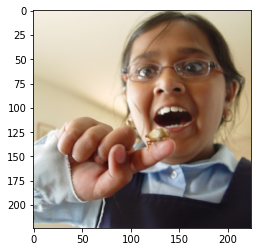

greedy search:  a man with a mohawk .
beam search 1:  a man with a mohawk .
beam search 3:  a young man with a white shirt .
beam search 5:  a man in a white shirt and blue shirt .


In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  for i in df_test['image'].sample(n=1).tolist():
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    image2 = image
    image2[0] = image2[0] * 0.229
    image2[1] = image2[1] * 0.224 
    image2[2] = image2[2] * 0.225 
    image2[0] += 0.485 
    image2[1] += 0.456 
    image2[2] += 0.406
    plt.imshow(image2.permute(1,2,0))
    plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    print('greedy search: ', greedy_predict(model, image, vocab, device, max_length = 30))
    print('beam search 1: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 1, show_step = False))
    print('beam search 3: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 3, show_step = False))
    print('beam search 5: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 5, show_step = False))


inference(df_test)

epoch:  1
Checkpoint saved


Train loss: 5.530221314991222


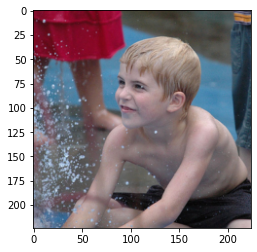

greedy search:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
beam search 1:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
beam search 3:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
beam search 5:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


val loss: 5.309898543509708
Checkpoint saved
epoch:  2
Checkpoint saved


Train loss: 4.032471597194672


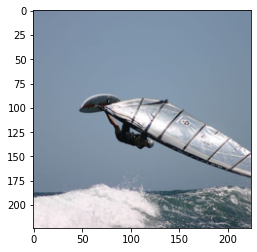

greedy search:  a person in a red jacket .
beam search 1:  a person in a red jacket .
beam search 3:  a person in a red jacket .
beam search 5:  a person in the snow in the snow .


val loss: 3.3947587316962564
Checkpoint saved
epoch:  3
Checkpoint saved


Train loss: 2.9669689370804475


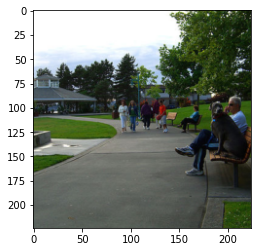

greedy search:  a man in a black shirt and white shirt .
beam search 1:  a man in a black shirt and white shirt .
beam search 3:  a man in a black shirt and white shirt .
beam search 5:  a man in a black shirt and white shirt .


val loss: 3.0403295231472915
Checkpoint saved
epoch:  4
Checkpoint saved


Train loss: 2.568211536447541


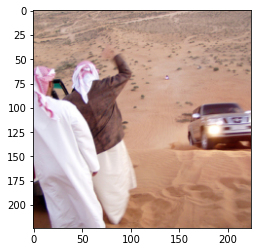

greedy search:  two girls are standing on the beach .
beam search 1:  two girls are standing on the beach .
beam search 3:  a woman in a red and white dress .
beam search 5:  a girl in a pink and white dress .


val loss: 2.9334746014540363
Checkpoint saved
epoch:  5
Checkpoint saved


Train loss: 2.2647650219312236


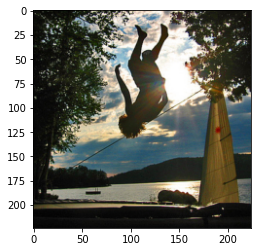

greedy search:  a person in a black pants .
beam search 1:  a person in a black pants .
beam search 3:  a person in a black pants .
beam search 5:  a person is in the air .


val loss: 2.902230106341611
Checkpoint saved
epoch:  6
Checkpoint saved


Train loss: 1.988970533639443


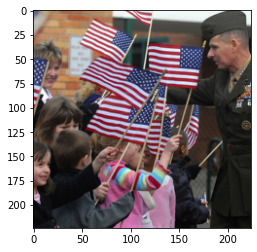

greedy search:  a man in a black shirt .
beam search 1:  a man in a black shirt .
beam search 3:  a crowd of people in a crowd .
beam search 5:  a group of men in a crowd .


val loss: 2.9399812434129653
Checkpoint saved
epoch:  7
Checkpoint saved


Train loss: 1.724400715166781


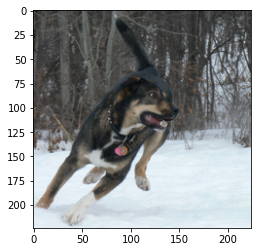

greedy search:  a dog in the snow .
beam search 1:  a dog in the snow .
beam search 3:  a brown and black dog in the snow .
beam search 5:  a brown and black dog in the snow .


val loss: 3.0266839926409874
Checkpoint saved
epoch:  8
Checkpoint saved


KeyboardInterrupt: ignored

In [ ]:
best_eval_loss = 10000
val_interval = 1

train_loss_list = []
val_loss_list = []

model.train() 
for epoch in range(num_epochs):
    print('epoch: ', epoch+1)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/ViTr.pth.tar')

    total_train_loss = 0
    step = 0

    for idx, (imgs, captions) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        step += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        output = model(imgs, captions) 
        optimizer.zero_grad()

        # captions shape: [batch_size ,sequence_length]
        # output.shape : [batch_size, sequence_length, vocab_size]
        # loss entropy loss:
            # input: (N, C)
            # output: (N)
        loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

        total_train_loss += loss.item()
        
        loss.backward()

        # CLIPPING Method
        clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
    
    scheduler.step()
    total_train_loss = total_train_loss / step
    train_loss_list.append(total_train_loss)
    print('Train loss: {}'.format(total_train_loss))
    
    
    ## for inference
    inference(df_test)

    val_total_loss = 0
    val_step = 0

    if (epoch + 1) % val_interval == 0:
      model.eval()
      with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
          val_step += 1
          imgs = imgs.to(device)
          captions = captions.to(device)

          output = model(imgs, captions) 
          loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

          val_total_loss += loss.item()        
          
        val_total_loss = val_total_loss / val_step
        val_loss_list.append(val_total_loss)
        print('val loss: {}'.format(val_total_loss))

      if val_total_loss < best_eval_loss:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/ViTr_Best.pth.tar')



In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/ViTr.txt', 'a') as testwritefile_train:
  for index, i in enumerate(train_loss_list):
    testwritefile_train.write('step :{}, loss score: {}\n'.format(index,i))

with open('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/ViTr.txt', 'a') as testwritefile_val:
  for index, i in enumerate(val_loss_list):
    testwritefile_val.write('step :{}, loss score: {}\n'.format(index,i))

In [ ]:
from collections import defaultdict
test_dic = defaultdict(list)

for i in range(len(df_test)):
  img = df_test.iloc[i,:]['image']
  caption = df_test.iloc[i,:]['caption']
  test_dic[img].append(caption)

In [ ]:
!pip install torchmetrics

from torchmetrics.functional import bleu_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  candidate_corpus_gp = []
  candidate_corpus_bm1 = []
  candidate_corpus_bm3 = []
  candidate_corpus_bm5 = []
  references_corpus = []

  for i in list(test_dic.keys()):
    test = [i.lower() for i in test_dic[i]]
    references_corpus.append(test)
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    # image2 = image
    # image2[0] = image2[0] * 0.229
    # image2[1] = image2[1] * 0.224 
    # image2[2] = image2[2] * 0.225 
    # image2[0] += 0.485 
    # image2[1] += 0.456 
    # image2[2] += 0.406
    # plt.imshow(image2.permute(1,2,0))
    # plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    gp = greedy_predict(model, image, vocab, device, max_length = 30)
    bm1 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 1, show_step = False)
    bm3 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 3, show_step = False)
    bm5 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 5, show_step = False)

    # print('greedy search: ', gp)
    # print('beam search 1: ', bm1)
    # print('beam search 3: ', bm3)
    # print('beam search 5: ', bm5)

    candidate_corpus_gp.append(gp)
    candidate_corpus_bm1.append(bm1)
    candidate_corpus_bm3.append(bm3)
    candidate_corpus_bm5.append(bm5)
    
  print('Greedy ')
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=1))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=2))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=3))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=4))

  print('BS 1')
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm1, references_corpus, n_gram=4))

  print('BS 3')
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=4))

  print('BS 5')
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=4))

    

inference(df_test)


Greedy 
tensor(0.5694)
tensor(0.3646)
tensor(0.2360)
tensor(0.1536)
BS 1
tensor(0.5694)
tensor(0.3646)
tensor(0.2359)
tensor(0.1536)
BS 3
tensor(0.6104)
tensor(0.3960)
tensor(0.2625)
tensor(0.1741)
BS 5
tensor(0.6036)
tensor(0.3897)
tensor(0.2569)
tensor(0.1690)


In [ ]:
model = CNN2Attention( vocab_size = vocab_size, device = device).to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/ViTr_Best.pth.tar')['state_dict'])

<All keys matched successfully>

In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  candidate_corpus_gp = []
  candidate_corpus_bm1 = []
  candidate_corpus_bm3 = []
  candidate_corpus_bm5 = []
  references_corpus = []

  for i in list(test_dic.keys()):
    test = [i.lower() for i in test_dic[i]]
    references_corpus.append(test)
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    # image2 = image
    # image2[0] = image2[0] * 0.229
    # image2[1] = image2[1] * 0.224 
    # image2[2] = image2[2] * 0.225 
    # image2[0] += 0.485 
    # image2[1] += 0.456 
    # image2[2] += 0.406
    # plt.imshow(image2.permute(1,2,0))
    # plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    gp = greedy_predict(model, image, vocab, device, max_length = 30)
    bm1 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 1, show_step = False)
    bm3 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 3, show_step = False)
    bm5 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 5, show_step = False)

    # print('greedy search: ', gp)
    # print('beam search 1: ', bm1)
    # print('beam search 3: ', bm3)
    # print('beam search 5: ', bm5)

    candidate_corpus_gp.append(gp)
    candidate_corpus_bm1.append(bm1)
    candidate_corpus_bm3.append(bm3)
    candidate_corpus_bm5.append(bm5)
    
  print('Greedy ')
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=1))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=2))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=3))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=4))

  print('BS 1')
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm1, references_corpus, n_gram=4))

  print('BS 3')
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=4))

  print('BS 5')
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=4))

    

inference(df_test)


KeyboardInterrupt: ignored